# 🎨 Classical Neural Style Transfer (Gatys et al., 2015)
Bu notebook, *A Neural Algorithm of Artistic Style* (Gatys et al., 2015) makalesinin PyTorch ile yeniden uygulanmış hâlidir.  
Amaç: içerik görselinin yapısını koruyarak stil görselinin renk ve dokularını aktarmak.

**Kullanılan Temel Kavramlar:**
- *Content Loss:* içerik özelliklerinin korunması  
- *Style Loss:* Gram Matrisi üzerinden stil istatistiklerinin yakalanması  
- *Total Variation Loss:* pürüzsüzlük sağlanması  
- *VGG19:* önceden eğitilmiş modelden ara katman aktivasyonları

**Formül:**
\
mathcal{L} = α x L_{content} + β x L_{style} + γ x L_{tv}



In [ ]:
#Kütüphaneler ve Ayarlar

import torch, torch.nn as nn, torch.optim as optim
import torchvision.models as models, torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Parametreler
CONTENT_IMG_PATH = "C:/Users/cagri/Desktop/NST/foto.jpg"
STYLE_IMG_PATH   = "../data/style/VanGogh-starry_night_ballance1.jpg"
OUTPUT_PATH      = "../results/output.jpg"
IMG_SIZE         = 512
CONTENT_LAYERS   = ['conv4_2']
STYLE_LAYERS     = ['conv1_1','conv2_1','conv3_1','conv4_1','conv5_1']
ALPHA, BETA, GAMMA = 1.0, 1e5, 1e-6
NUM_STEPS = 500
PRINT_EVERY = 50


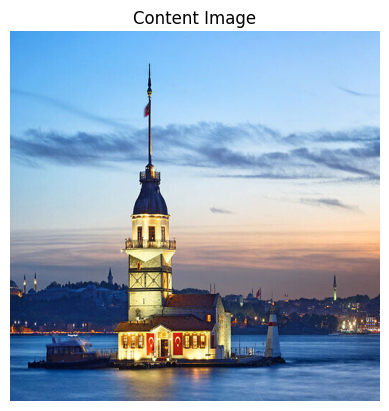

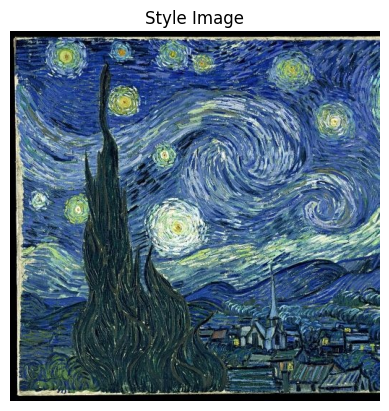

In [16]:
#Görsel Yükleme Fonksiyonları

def load_image(path, size=IMG_SIZE):
    img = Image.open(path).convert("RGB")
    transform = T.Compose([
        T.Resize(size),
        T.CenterCrop(size),
        T.ToTensor()
    ])
    return transform(img).unsqueeze(0)

def imshow(tensor, title=None):
    img = tensor.clone().detach().squeeze(0).clamp(0,1)
    plt.imshow(img.permute(1,2,0))
    if title: plt.title(title)
    plt.axis("off")
    plt.show()

content = load_image(CONTENT_IMG_PATH).to(device)
style   = load_image(STYLE_IMG_PATH).to(device)
imshow(content, "Content Image")
imshow(style, "Style Image")


In [17]:
#Özellik Çıkarımı & Gram Matrix

class VGGFeatures(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features.eval()
        for p in vgg.parameters(): p.requires_grad_(False)
        self.vgg = vgg.to(device)
        self.map = {'conv1_1':1,'conv2_1':6,'conv3_1':11,'conv4_1':20,'conv4_2':21,'conv5_1':29}
        self.norm = T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    def forward(self, x, layers):
        x = self.norm(x)
        feats = {}
        for i, layer in enumerate(self.vgg):
            x = layer(x)
            for name, idx in self.map.items():
                if i == idx and name in layers:
                    feats[name] = x
        return feats

def gram_matrix(feat):
    N,C,H,W = feat.size()
    F = feat.view(N,C,H*W)
    return torch.bmm(F, F.transpose(1,2)) / (C*H*W)

In [18]:
#NST Eğitim Döngüsü

def total_variation_loss(img):
    x_diff = img[:,:,1:,:]-img[:,:,:-1,:]
    y_diff = img[:,:,:,1:]-img[:,:,:,:-1]
    return (x_diff.pow(2).mean()+y_diff.pow(2).mean())

def run_nst(content, style, steps=NUM_STEPS):
    extractor = VGGFeatures()
    with torch.no_grad():
        content_feats = extractor(content, CONTENT_LAYERS)
        style_feats   = extractor(style, STYLE_LAYERS)
        style_grams   = {l: gram_matrix(style_feats[l]) for l in STYLE_LAYERS}

    generated = content.clone().requires_grad_(True)
    optimizer = optim.LBFGS([generated], max_iter=steps)

    losses = {'total': [], 'content': [], 'style': []}
    step = [0]
    def closure():
        optimizer.zero_grad()
        c_feats = extractor(generated, CONTENT_LAYERS)
        s_feats = extractor(generated, STYLE_LAYERS)

        c_loss = sum(nn.functional.mse_loss(c_feats[l], content_feats[l]) for l in CONTENT_LAYERS)
        s_loss = sum(nn.functional.mse_loss(gram_matrix(s_feats[l]), style_grams[l]) for l in STYLE_LAYERS)
        tv_loss = total_variation_loss(generated)

        loss = ALPHA*c_loss + BETA*s_loss + GAMMA*tv_loss
        loss.backward()

        if step[0] % PRINT_EVERY == 0:
            print(f"Step {step[0]} | Total {loss.item():.2f} | C {c_loss.item():.2f} | S {s_loss.item():.2f}")
            losses['total'].append(loss.item())
            losses['content'].append(c_loss.item())
            losses['style'].append(s_loss.item())
        step[0]+=1
        return loss

    optimizer.step(closure)
    return generated.detach(), losses


Step 0 | Total 27.58 | C 0.00 | S 0.00
Step 50 | Total 2.23 | C 0.82 | S 0.00
Step 100 | Total 1.88 | C 0.70 | S 0.00
Step 150 | Total 1.74 | C 0.65 | S 0.00
Step 200 | Total 1.66 | C 0.63 | S 0.00
Step 250 | Total 1.61 | C 0.61 | S 0.00
Step 300 | Total 1.57 | C 0.60 | S 0.00
Step 350 | Total 1.54 | C 0.59 | S 0.00
Step 400 | Total 1.52 | C 0.58 | S 0.00
Step 450 | Total 1.50 | C 0.57 | S 0.00


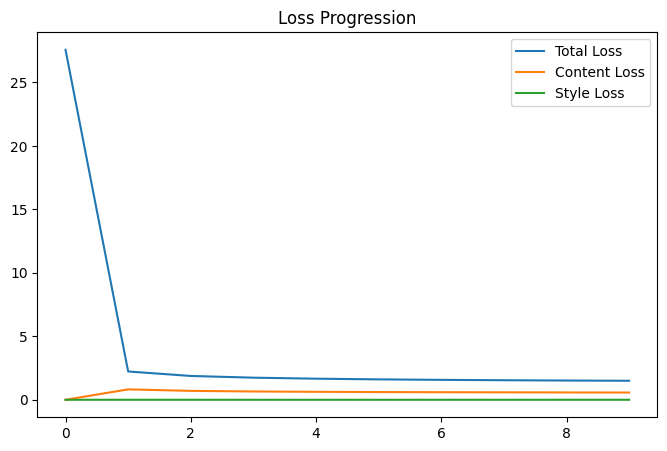

In [19]:
#Eğitimi Başlat & Loss Grafiği

output, losses = run_nst(content, style)

plt.figure(figsize=(8,5))
plt.plot(losses['total'], label="Total Loss")
plt.plot(losses['content'], label="Content Loss")
plt.plot(losses['style'], label="Style Loss")
plt.legend(); plt.title("Loss Progression")
plt.show()


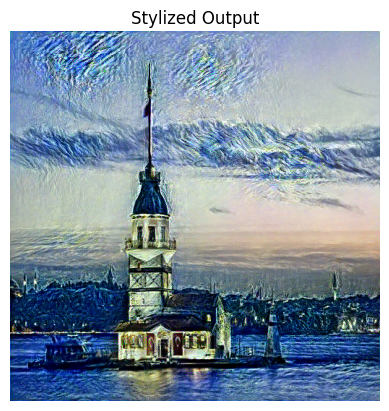

Saved: ../results/output.jpg


In [20]:
#Çıktıyı Görüntüle & Kaydet

def tensor_to_pil(t):
    t = t.clamp(0,1).cpu().squeeze(0)
    return T.ToPILImage()(t)

imshow(output, "Stylized Output")
tensor_to_pil(output).save(OUTPUT_PATH)
print("Saved:", OUTPUT_PATH)

### 🔍 Gözlem
- **Content Weight (α)** içeriğin korunma oranını belirler.  
- **Style Weight (β)** ne kadar stil baskın olacağını belirler.  
- **Total Variation (γ)** gürültüyü azaltır.

> β = 1e5 civarında güçlü stilizasyon,  
> β = 1e4 civarında daha doğal sonuçlar verir.

Farklı stillerle çıktılar deneyerek sonuçları `outputs/` klasörüne kaydedebilirsiniz.
